In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.stats import norm, skew

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, train_test_split, GridSearchCV, cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
pd.options.mode.chained_assignment = None

COUNT = 100
TEST_PERCEN = 0.20
RANDOM_STATE = 0
REPEATS = 5

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
### Reading CSV File
def load_data():
    Data = pd.read_csv('Feature_sets/Features_RNAalign.csv')
    pd.set_option('display.max_columns', None)
    return Data

In [4]:
def labeling(Data):
    Data.columns = Data.columns.str.replace(' ', '')
    Data['motif_family'] = Data['motif_family'].str.replace(' ', '')   
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6, 'Rope-sling': 7, 'Tetraloop-receptor': 8, 'reverse-Kink-turn': 9, 'L1-complex': 10, 'T-loop': 11}    
    Data.motif_family = [family[item] for item in Data.motif_family]
    Data = Data.drop(['motif_str'], axis = 1)
    return Data

In [5]:
def check_class_bias(Data):
    print('------------- Distribution of Class in the Label Column -------------')
    
    mapp = {1: 'TS', 2: 'EL', 3: 'SR', 4: 'KT', 5: 'HT', 6: 'CL', 7: 'RS', 8: 'TR', 9: 'rKT', 10: 'L1C', 11: 'TL'}
    Data['Family'] = Data["motif_family"].copy()
    Data.Family = [mapp[item] for item in Data.Family]
    item_counts = Data["Family"].value_counts()
    print(item_counts)
    print ('----------------------------')
    sns.set(font_scale=1.5)
    f, ax = plt.subplots(figsize=(12, 9))
    ax = sns.countplot(x="Family", data=Data, label="Label Count")
    sns.despine(bottom=True)
    Data = Data.drop('Family', axis = 1)
    return Data

------------- Distribution of Class in the Label Column -------------
SR     73
KT     66
EL     48
TS     44
CL     43
HT     33
TR     18
RS     11
rKT     7
L1C     5
TL      1
Name: Family, dtype: int64
----------------------------


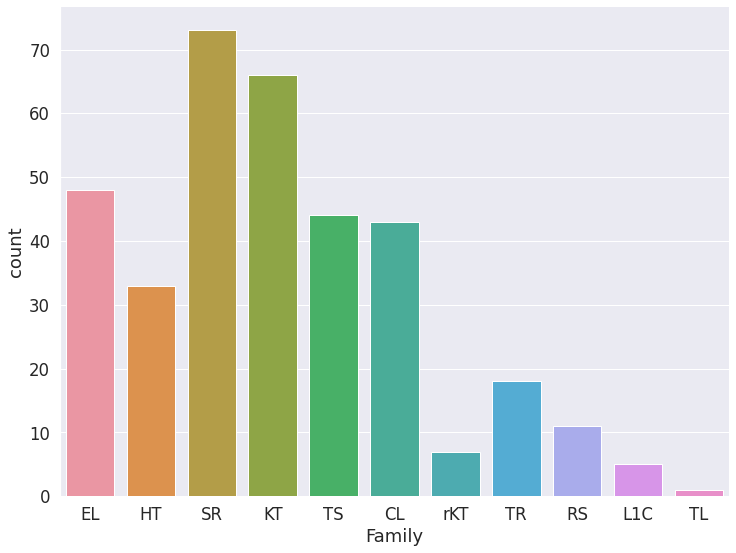

In [6]:
Data = load_data()
Data = labeling(Data)
# Separating Features and Label Column
Data = check_class_bias(Data)

## Selected motif families based on coordinate-based similarity
<p> Families with high similarity: Tandem-shear (TS), E-loop (EL), Hook-turn (HT), C-loop (CL) <br>
Families with low similarity: Sarcin-ricin(SR) </p>

In [7]:
def Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, SPLIT):
    ####################################################################
    cv_method = RepeatedStratifiedKFold(n_splits=SPLIT, 
                                        n_repeats=REPEATS, 
                                        random_state=RANDOM_STATE)

    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

    gs_NB = GridSearchCV(estimator=GaussianNB(), 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='accuracy')
        
    #########################################
    Data_transformed_X = PowerTransformer().fit_transform(X)

    ######################## Score #################
    scorer = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
    }
    scores = cross_validate(gs_NB, X, Y, scoring=scorer, cv=cv_method, n_jobs=-1)
    print('Accuracy: %.3f, Sensitivity: %.3f, Specificity: %.3f' % (np.mean(scores['test_accuracy']), np.mean(scores['test_sensitivity']), np.mean(scores['test_specificity'])))  

## GNB Binary Classifier for EL
<p> Class 1: EL <br>
Class 0: TS, HT, CL, SR </p>

In [8]:
def Data_Preprocess_EL(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]
 
    ##### E-loop #####
    EL_map = {2:1, 1:0, 3:0, 5:0, 6:0}
    Data_Filtered.motif_family = [EL_map[item] for item in Data_Filtered.motif_family]    
    
    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
    
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [46]:
Data = load_data()
Data = labeling(Data)
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_EL(Data)
print("EL performance evaluation:")
Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, 3)

EL performance evaluation:
Accuracy: 0.771, Sensitivity: 0.879, Specificity: 0.662


## GNB Binary Classifier for TS
<p> Class 1: TS <br>
Class 0: EL, HT, CL, SR </p>

In [10]:
def Data_Preprocess_TS(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]

 
    ##### Tandem-shear #####
    TS_map = {1:1, 2:0, 3:0, 5:0, 6:0}
    Data_Filtered.motif_family = [TS_map[item] for item in Data_Filtered.motif_family]    
    
    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
   
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [33]:
Data = load_data()
Data = labeling(Data)
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_TS(Data)
print("TS performance evaluation:")
Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, 3)

TS performance evaluation:
Accuracy: 0.837, Sensitivity: 0.887, Specificity: 0.788


## GNB Binary Classifier for HT
<p> Class 1: HT <br>
Class 0: EL, TS, CL, SR </p>

In [12]:
def Data_Preprocess_HT(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]
 
    ##### Hook-turn #####
    HT_map = {5:1, 1:0, 2:0, 3:0, 6:0}
    Data_Filtered.motif_family = [HT_map[item] for item in Data_Filtered.motif_family]    
    
    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
    
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [61]:
Data = load_data()
Data = labeling(Data)
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_HT(Data)
print("HT performance evaluation:")
Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, 3)

HT performance evaluation:
Accuracy: 0.739, Sensitivity: 0.806, Specificity: 0.673


## GNB Binary Classifier for CL
<p> Class 1: CL <br>
Class 0: EL, TS, HT, SR </p>

In [14]:
def Data_Preprocess_CL(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]

    ##### C-loop #####
    CL_map = {6:1, 1:0, 2:0, 3:0, 5:0}
    Data_Filtered.motif_family = [CL_map[item] for item in Data_Filtered.motif_family]    
    
    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
    
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [68]:
Data = load_data()
Data = labeling(Data)
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_CL(Data)
print("CL performance evaluation:")
Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, 3)

CL performance evaluation:
Accuracy: 0.819, Sensitivity: 0.818, Specificity: 0.818


## GNB Binary Classifier for SR
<p> Class 1: SR <br>
Class 0: EL, TS, HT, CL </p>

In [16]:
def Data_Preprocess_SR(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]

    ##### Sarcin-ricin #####
    SR_map = {3:1, 1:0, 2:0, 5:0, 6:0}
    Data_Filtered.motif_family = [SR_map[item] for item in Data_Filtered.motif_family]    
    
    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
    
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [111]:
Data = load_data()
Data = labeling(Data)
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_SR(Data)
print("SR performance evaluation:")
Hyper_Tuning(X, Y, x_train, x_test, y_train, y_test, 3)

SR performance evaluation:
Accuracy: 0.910, Sensitivity: 0.853, Specificity: 0.967


## GNB Multi-class classifier

In [18]:
### Drop class 0
def Data_Preprocess_TS_EL_HT_CL_SR(Data):
    
    family = {'Tandem-shear': 1, 'E-loop': 2, 'Sarcin-ricin': 3, 'Kink-turn': 4, 'Hook-turn': 5, 'C-loop': 6} 
    
    Data = Data[Data["motif_family"] != 11]
    Data = Data[Data["motif_family"] != 10]
    Data = Data[Data["motif_family"] != 9]
    Data = Data[Data["motif_family"] != 8]
    Data = Data[Data["motif_family"] != 7]
    Data_Filtered = Data[Data["motif_family"] != 4]

    Balance_Data = Data_Filtered.groupby('motif_family')
    Data_Filtered = pd.DataFrame(Balance_Data.apply(lambda x: x.sample(Balance_Data.size().min()).reset_index(drop=True)))
    
    X = Data_Filtered.drop('motif_family', axis = 1)
    Y = Data_Filtered['motif_family']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = TEST_PERCEN, random_state = 0)
    return X, Y, x_train, x_test, y_train, y_test

In [19]:
def Hyper_Tuning_Multiclass(X, Y, x_train, x_test, y_train, y_test):
    ####################################################################
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn.preprocessing import PowerTransformer
    from sklearn.metrics import precision_recall_fscore_support as score
    
    cv_method = RepeatedStratifiedKFold(n_splits=3, 
                                        n_repeats=5, 
                                        random_state=991)
  
    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

    gs_NB = GridSearchCV(estimator=GaussianNB(), 
                         param_grid=params_NB, 
                         cv=cv_method,
                         verbose=1, 
                         scoring='accuracy')
    

    #########################################
    Data_transformed_X = PowerTransformer().fit_transform(X)

    ######################## Score #################
    scorer = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score, average='weighted'),
    'specificity': make_scorer(recall_score, pos_label=0, average='weighted')
    }

    scores = cross_validate(gs_NB, X, Y, scoring=scorer, cv=cv_method, n_jobs=-1)
    print('Accuracy: %.3f' % (np.mean(scores['test_accuracy'])))  
    

In [74]:
X, Y, x_train, x_test, y_train, y_test = Data_Preprocess_TS_EL_HT_CL_SR(Data)
Hyper_Tuning_Multiclass(X, Y, x_train, x_test, y_train, y_test)

Accuracy: 0.722
